# Unit 2 | Question 4 - Data Bias Application
---

### Assignment
Explain the impact and effect of bias on the integrity and usability of data, then apply appropriate validation and verification methods to your data.


---

### Synthetic Credit Approval Dataset

A synthetic dataset is an artificially generated data that mimics the statistical properties and patterns of real-world data, but doesn’t contain actual personal or sensitive information. The csv file has 6 columns: 
- Number of children (integer)
- Group (sgnification unknown)
- Income
- Car Owner (indicator)
- Home owner (indicator)
- Target (indicator)

We are verifying whether we could have a selection bias, with a positive skewed distribution of income. Contrary to normal distribution with a symmetrical, bell shaped repartition, skewed data has a tail on either side of the graph. A positive skew distribution has a tail on the positive side. Most datasets coming from the real-world are actually asymmetrical, hence the need to understand skewed data, and apply specific methods to identify it.

To check for biases, I will apply the steps presented in Indeed article https://www.indeed.com/career-advice/career-development/skewed-data:
1. Find the mean, median, and standard deviation
2. Use skew and kurtosis formula 
3. Use a boxplot
4. Transform your skewed data - exponential, power, or log transformation

---

### *Setup*

### *⚠️ Install - Run only once*

In [ ]:
# !pip install -r ../requirements.txt
# !pip install --upgrade jupyterlab ipywidgets tqdm

### Imports

In [15]:
import kagglehub 
import os 
import shutil
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import numpy as np
import seaborn as sns
import warnings


---

### Data Ingestion 

In [2]:

data_folder_path = '../data'
dataset_nm = 'alexisbcook/synthetic-credit-card-approval'
file_nm = "synthetic_credit_card_approval.csv"
file_path = data_folder_path + '/' + file_nm

if not os.path.exists(data_folder_path):
    os.makedirs(data_folder_path)

if os.path.isfile(data_folder_path + '/' + file_nm):
    print("\n\n1. Dataset file already exists. Skipping download.")
else:
    # Download latest version from kaggle and move file to data folder
    # Only run in local installation (not in colab)
    try:
        os.environ['KAGGLEHUB_CACHE'] = data_folder_path
        path = kagglehub.dataset_download(dataset_nm)
        os.replace(path + '/' + 'synthetic_credit_card_approval.csv', data_folder_path + '/' + 'synthetic_credit_card_approval.csv')
        shutil.rmtree(data_folder_path + '/datasets')
        print("\n1. Dataset downloaded and moved to data folder.")
    
    except Exception as e:
        print(f"An error occurred: {e}")

try:
  df = pd.read_csv(file_path)
  print("2. Data successfully loaded.\n")

except FileNotFoundError:
  print(f"Error: File '{file_path}' not found. Please check the file path and filename.")

except Exception as e:
    print(f"An error occurred: {e}")
    



1. Dataset file already exists. Skipping download.
2. Data successfully loaded.



---

### 1. Mean, median, and standard deviation analysis

In [3]:
# Inspecting file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Num_Children  500000 non-null  int64
 1   Group         500000 non-null  int64
 2   Income        500000 non-null  int64
 3   Own_Car       500000 non-null  int64
 4   Own_Housing   500000 non-null  int64
 5   Target        500000 non-null  int64
dtypes: int64(6)
memory usage: 22.9 MB


In [4]:
df.head(10)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1
5,0,1,114086,1,0,1
6,2,0,37055,1,0,0
7,2,1,83130,1,1,1
8,2,1,81965,1,0,1
9,3,0,35094,1,0,0


In [5]:
# The describe() function to quickly find mean and median (50%) 
df["Income"].describe()

count    500000.000000
mean      72507.446898
std       22960.209440
min       30000.000000
25%       53321.000000
50%       72060.000000
75%       90670.250000
max      119999.000000
Name: Income, dtype: float64



**ℹ️ Comments based on mean, median, and standard deviation**

Mean and median (50th percentile) for the income attribute are quite close—72,507.45 vs 72,060—suggesting limited skewness. However, the standard deviation shows a large spread, with data points varying by roughly a third of the mean (22,960.21). The mean being slightly higher than the median could indicate a mild positive skew, hinting at a possible selection bias, where higher-income demographics are overrepresented.

Without information about the currency, location (country or city), or income definition (gross or net), interpretation remains uncertain. For instance, an average household income of 72,500 would be considered relatively high in countries like France (EUR) or the UK (GBP). These gaps in context also raise the possibility of a sample bias, where data may have been drawn primarily from wealthier or privileged areas, inflating the apparent average income level.

Such questions could likely be resolved by understanding the scope of the analysis and the data provider—particularly if the source comes from a sector like luxury goods, where higher incomes would naturally dominate.

---

### 2. Using skew formula, kurtosis

*The following code was generated with the assistance of ChatGPT (GPT-5).*

**PROMPT**: Generate Python code (for use in a Jupyter notebook) that visualizes the distribution of a numerical variable. The chart should use a histogram with bins of appropriate width (for example, 5k income intervals), overlay a Gaussian (normal) curve based on the variable’s mean and standard deviation, include dot markers (or another clear representation) of bin frequencies. Label axes, add a clear title, and use visually balanced colors. Optionally, include code to compute and display **mean, median, skewness, and kurtosis**.  
For transparency and reproducibility, add a comment that the visualization code was generated with the assistance of an AI model (**ChatGPT, GPT-5**).




**Comparing household income distribution with a normal distribution**

We are starting with a simple check, comparing the count of household earning a given income in the dataset distribution, with the expected value with a normal distribution. We use an histogram to represent the count of household per group of income, overlayed by a Gaussian curve.

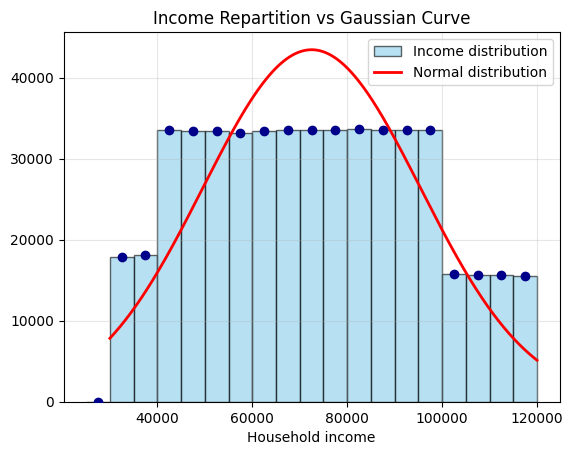

In [6]:

def plot_income_distribution(data_lst, bin_size_int=5000, title_str='Distribution vs Normal Curve', xlabel_str=''):

    # Plots a histogram with a normal distribution curve and bin centers.
    
    # Parameters:
    #    data_lst (list or pd.Series): List/Series of values.
    #    bin_size_int (int, optional): Size of each bin in histogram. Default is 5000.
    #    title_str (str, optional): Plot title.
    #    xlabel_str (str, optional): Label for the x-axis.
    
    mean_flt = data_lst.mean()
    std_flt = data_lst.std()

    # Define bins
    bins_lst = np.arange(data_lst.min() - bin_size_int, data_lst.max() + bin_size_int, bin_size_int)

    # Histogram
    counts, bins, patches = plt.hist(data_lst, bins=bins_lst, alpha=0.6, color='skyblue', edgecolor='black', label='Income distribution')

    # Normal curve
    x = np.linspace(data_lst.min(), data_lst.max(), 1000)
    pdf = norm.pdf(x, mean_flt, std_flt)
    pdf_scaled = pdf * (len(data_lst) * (bins[1] - bins[0]))
    plt.plot(x, pdf_scaled, color='red', linewidth=2, label='Normal distribution')

    # Bin centers
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.scatter(bin_centers, counts, color='darkblue', zorder=3)

    # Labels and title
    plt.xlabel(xlabel_str)
    plt.title(title_str)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_income_distribution(df["Income"], title_str='Income Repartition vs Gaussian Curve', xlabel_str='Household income')

On the graph, that higher income trail might seem a slightly overrepresented when compare to the trend of a Gaussian curve. Running the skewness and kurtosis calculation will help validate or not the bias hypothesis.

**Skewness and kurtosis**

In [9]:
def calculate_skewness_kurtosis(data_lst):

    # Calculate skewness and kurtosis of a distribution and provide a basic interpretation.
    
    # Parameters:
    #    data_lst (list or pd.Series): List/Series of values.

    
    # Compute skewness and kurtosis
    skew_float = skew(data_lst)
    kurt_float = kurtosis(data_lst)
    
    # Display results
    print("")
    print(f"Skewness: {skew_float:.3f}")
    print(f"Kurtosis: {kurt_float:.3f}")
    
    # Interpret skewness
    if skew_float > 0.5:
        skew_str = "positively skewed (right tail)"
    elif skew_float < -0.5:
        skew_str = "negatively skewed (left tail)"
    else:
        skew_str = "approximately symmetric"
    
    # Interpret kurtosis
    if kurt_float > 0.5:
        kurt_str = "leptokurtic (heavy tails / outliers likely)"
    elif kurt_float < -0.5:
        kurt_str = "platykurtic (flatter, fewer outliers)"
    else:
        kurt_str = "mesokurtic (close to normal)"
    
    print(f"\nInterpretation:")
    print(f"- The distribution is {skew_str}.")
    print(f"- The distribution is {kurt_str}.\n")
    
    # Optional bias insights
    if skew_float > 0.5:
        print("⚠️ Positive skew may suggest sampling or selection bias — perhaps high-income households are overrepresented.")
    elif skew_float < -0.5:
        print("⚠️ Negative skew could indicate data truncation — e.g., low-income groups underrepresented.")

calculate_skewness_kurtosis(df["Income"])


Skewness: 0.113
Kurtosis: -0.956

Interpretation:
- The distribution is approximately symmetric.
- The distribution is platykurtic (flatter, fewer outliers).



The skewness and the kurtosis does not indicate that this dataset has a sampling or selection bias. The following step is to search for outliers with a boxplot. 

### 3. Boxplot

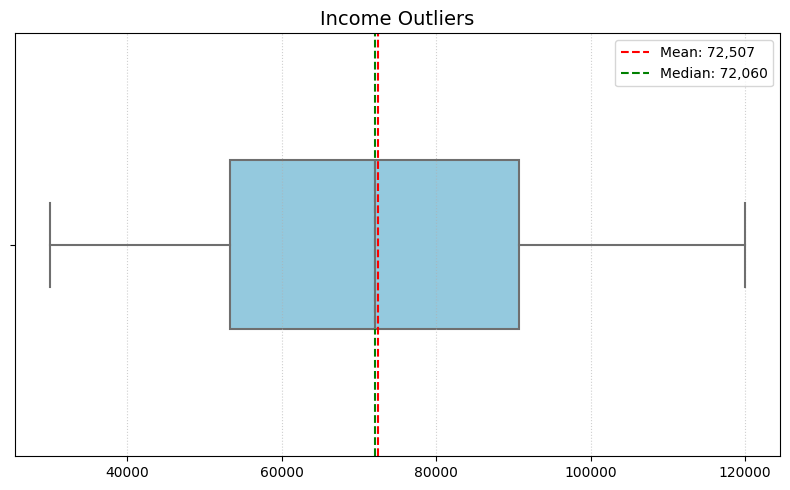

Q1: 53,321 | Q3: 90,670 | IQR: 37,349
Mean: 72,507 | Median: 72,060


In [10]:

def plot_boxplot(data_lst, title_str='Boxplot', xlabel_str=''):
    
    # Calculate skewness and kurtosis of a distribution and provide a basic interpretation.
    
    # Parameters:
    #    data_lst (list or pd.Series): List/Series of values.
    #    title_str (str, optional): Plot title.
    #    xlabel_str (str, optional): Label for the x-axis.
    
    # Calculation of descriptive statistics
    mean_flt = np.mean(data_lst)
    median_flt = np.median(data_lst)
    q1, q3 = np.percentile(data_lst, [25, 75])
    iqr = q3 - q1
    
    # Creating the boxplot
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data_lst, color="skyblue", width=0.4, fliersize=5)
    
    # Adding reference lines
    plt.axvline(mean_flt, color='red', linestyle='--', label=f'Mean: {mean_flt:,.0f}')
    plt.axvline(median_flt, color='green', linestyle='--', label=f'Median: {median_flt:,.0f}')
    
    # Chart formatting
    plt.title(title_str, fontsize=14)
    plt.xlabel(xlabel_str, fontsize=12)
    plt.legend()
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Optional: display statistics
    print(f"Q1: {q1:,.0f} | Q3: {q3:,.0f} | IQR: {iqr:,.0f}")
    print(f"Mean: {mean_flt:,.0f} | Median: {median_flt:,.0f}")

plot_boxplot(df["Income"], title_str='Income Outliers')

On this boxplot, we don't see any outliers (points outside the 1,5 * interquartile range). So no data needs to be taken out of the source.

### 4. Transform your skewed data - exponential, power, or log transformation

*The following code was generated with the assistance of ChatGPT (GPT-5).*

**PROMPT**: Generate Python code (for use in a Jupyter notebook) that demonstrates how to reduce skewness in a numerical dataset using mathematical transformations. The code should: create a sample positively skewed dataset (for example, household incomes using an exponential distribution); apply log, square root, and power (Box–Cox) transformations to make the distribution more symmetric; 
For the visualisation, please use NumPy, SciPy, and Seaborn/Matplotlib for the calculations and visualizations; display a histogram before and after transformation, showing the effect on the shape of the distribution; compute and print skewness before and after transformation, and include the Box–Cox lambda value. Use clear titles, labels, and colors for professional readability.
Add a note that the visualization and transformation code was generated with the assistance of an AI model (ChatGPT, GPT-5) for transparency and reproducibility.

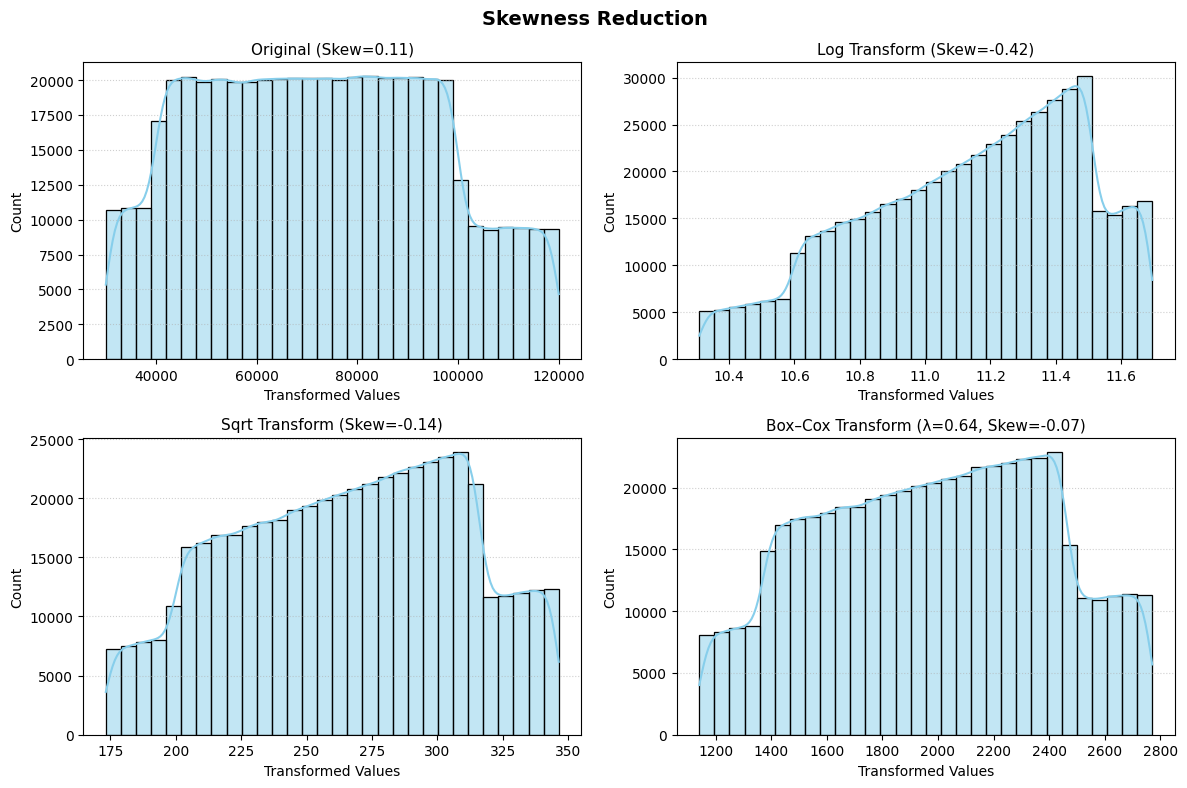

Skewness comparison:
  Original: 0.11
  Log Transform: -0.42
  Sqrt Transform: -0.14
  Box–Cox Transform: -0.07 (λ=0.64)


In [16]:

def skewness_reduction(data_lst, suptitle_str='Skewness Reduction', xlabel_str='Transformed Values'):
    
    # Apply and display skewed distribution after having applying transformation 
    
    # Parameters:
    #    data_lst (list or pd.Series): List/Series of values.
    #    suptitle_str (str, optional): Main title for the all graph.
    #    xlabel_str (str, optional): X-axis label (same for each transformation).
    
    # Suppress only specific warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 2. Define transformations (filter out non-positive values for log/Box–Cox)
    positive_data_lst = data_lst[data_lst > 0]
    
    # Transformations
    log_transformed_lst = np.log(positive_data_lst)
    sqrt_transformed_lst = np.sqrt(positive_data_lst)
    boxcox_transformed_lst, fitted_lambda_flt = stats.boxcox(positive_data_lst)
    
    # 3. Compute skewness before and after
    skew_original_flt = stats.skew(data_lst)
    skew_log_flt = stats.skew(log_transformed_lst)
    skew_sqrt_flt = stats.skew(sqrt_transformed_lst)
    skew_boxcox_flt = stats.skew(boxcox_transformed_lst)
    
    # 4. Plot histograms
    fig_img, axe_lst = plt.subplots(2, 2, figsize=(12, 8))
    title_lst = [
        f"Original (Skew={skew_original_flt:.2f})",
        f"Log Transform (Skew={skew_log_flt:.2f})",
        f"Sqrt Transform (Skew={skew_sqrt_flt:.2f})",
        f"Box–Cox Transform (λ={fitted_lambda_flt:.2f}, Skew={skew_boxcox_flt:.2f})"
    ]
    dataset_lst = [data_lst, log_transformed_lst, sqrt_transformed_lst, boxcox_transformed_lst]
    
    for ax, data, title in zip(axe_lst.flat, dataset_lst, title_lst):
        sns.histplot(data, bins=30, kde=True, color="skyblue", ax=ax)
        ax.set_title(title, fontsize=11)
        ax.set_xlabel(xlabel_str)
        ax.grid(axis="y", linestyle=":", alpha=0.6)
    
    plt.suptitle(suptitle_str, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. Print summary
    print(f"Skewness comparison:")
    print(f"  Original: {skew_original_flt:.2f}")
    print(f"  Log Transform: {skew_log_flt:.2f}")
    print(f"  Sqrt Transform: {skew_sqrt_flt:.2f}")
    print(f"  Box–Cox Transform: {skew_boxcox_flt:.2f} (λ={fitted_lambda_flt:.2f})")

skewness_reduction(df["Income"])

These transformations—logarithm, square root, and Box-Cox—have been selected to reduce skewness. We can observe that the values on the x-axis, which are used to train the model, are now closer to one another. This prevents higher values from having an excessive influence on the overall model. For reporting or visualization, we can simply apply the inverse transformation to display values consistent with the original dataset.